In [2]:
# 加载飞浆及相关的库
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import os
import gzip
import json
import random

In [4]:
# 定义数据集读取器
def load_data(mode='train'):
    # 声明数据集文件位置
    datafile = r'../datasets/mnist.json.gz'
    print('Loading mnist dataset from {} ...'.format(datafile))

    # 加载json数据文件
    data = json.load(gzip.open(datafile))
    print('MNIST dataset load done')
    
    # 划分训练集、验证集、测试集
    train_set, val_set, test_set = data
    
    # 图像高度和宽度
    IMG_ROWS = 28
    IMG_COLS = 28
    
    if mode=='train':
        imgs, labels = train_set[0], train_set[1]
    elif mode=='valid':
        imgs, labels = val_set[0], val_set[1]
    elif mode=='test':
        imgs, labels = test_set[0], test_set[1]
    else:
        raise Exception("Mode can only be one of ['train', 'valid', 'test']")
    print('数据集长度：', len(imgs))
    
    # 校验数据
    imgs_length = len(imgs)
    
    assert len(imgs) == len(labels), \
        "Length of imgs({}) should be the same as labels({})".format(len(imgs), len(labels))
        
    # 定义训练数据集每项数据的序号，根据序号读取数据
    index_list = list(range(imgs_length))

    # 读入数据时用到的批次大小
    BATCHSIZE = 100
    
    # 定义数据生成器，返回批次数据
    def data_generator():
        if mode == 'train':
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        for i in index_list:
            # 将数据转换成需要的类型
            # img = np.array(imgs[i]).astype('float32')
            # label = np.array(labels[i]).astype('float32')
            # 使用卷积神经网络
            img = np.reshape(imgs[i], [1, IMG_ROWS, IMG_COLS]).astype('float32')
            label = np.reshape(labels[i], [1]).astype('float32')
            # 把当前数据加入列表
            imgs_list.append(img)
            labels_list.append(label)
            if len(imgs_list) == BATCHSIZE:
                # 获得一个批次的数据并返回
                # 将生成器设置为yield模式，以减少内存占用
                yield np.array(imgs_list), np.array(labels_list)
                # 清空数据列表
                imgs_list = []
                labels_list = []

        # 如果最后剩余的数据长度小于BATCHSIZE，则自动构成一个批次
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)

    return data_generator

## 经典的全连接神经网络

经典的全连接神经网络包含四层网络：输入层、两个隐含层和输出层：
- 输入层：将数据输入给神经网络。
- 隐含层：增加网络深度和复杂度，隐含层的节点数是可以调整的，节点数越多，神经网络表示能力越强，参数量也会增加。通常隐含层会比输入层的尺寸小，以便对关键信息做抽象，激活函数使用常见的Sigmoid函数。
    - 隐含层引入非线性激活函数Sigmoid是为了增加神经网络的非线性能力。
- 输出层：输出网络计算结果，输出层的节点数是固定的。如果是回归问题，节点数量为需要回归的数字数量；如果是分类问题，则是分类标签的数量。

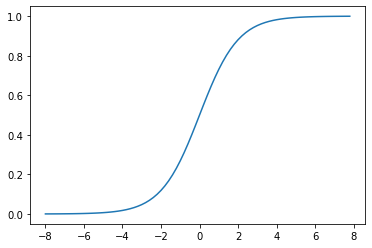

In [11]:
# Sigmoid是早期神经网络模型中常见的非线性变换函数
# 绘制Sigmoid的函数曲线
def sigmoid(x):
    # 直接返回sigmoid函数
    return 1 / (1 + np.exp(-x))

# Params: 起点、终点、间距
x = np.arange(-8, 8, 0.2)
y = sigmoid(x)
plt.plot(x, y)
plt.show()

In [10]:
"""经典的全连接神经网络

针对手写数字识别任务的网络结构设计：
- 输入层的尺寸为28 * 28， 但批次计算的时候会增加一个维度（大小为batch size）。
- 中间的两个隐含层为10 * 10的结构，激活函数使用常见的Sigmoid函数。
- 模型的输出是回归一个数字，输出层的尺寸设置为1。
"""

class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        # 定义两层全连接隐含层，输出维度是10，设定隐含节点数为10
        self.fc1 = Linear(in_features=784, out_features=10)
        self.fc2 = Linear(in_features=10, out_features=10)
        # 定义一层全连接输出层，输出维度是1
        self.fc3 = Linear(in_features=10, out_features=1)
    
    # 定义网络的前向计算
    # 隐含层使用Sigmoid激活函数，输出层不使用激活函数
    def forward(self, inputs):
        # inputs = paddle.reshape(inputs, [inputs.shape[0], 784])
        outputs1 = self.fc1(inputs)
        outputs1 = F.sigmoid(outputs1)
        outputs2 = self.fc2(outputs1)
        outputs2 = F.sigmoid(outputs1)
        outputs_final = self.fc3(outputs2)
        return outputs_final

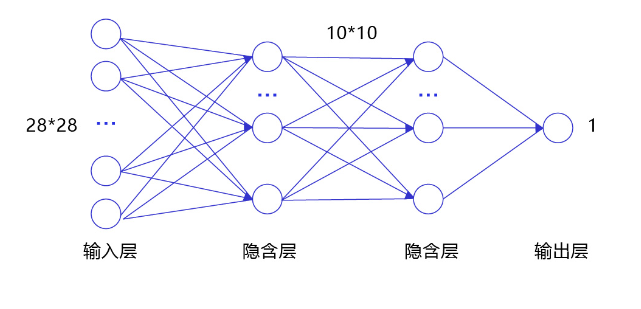

## 卷积神经网络

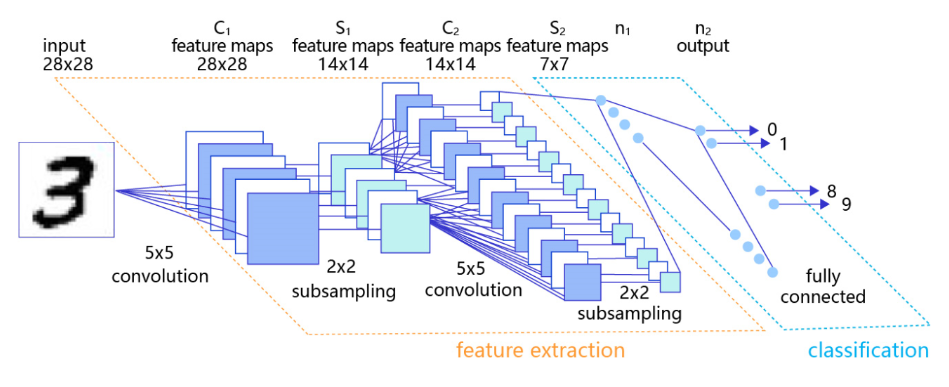

In [5]:
"""卷积神经网络

对于计算机视觉问题，效果最好的模型是卷积神经网络。
卷积神经网络针对视觉问题的特点进行了网络结构优化，可以直接处理原始形式的图像数据，保留像素间的空间信息。

卷积神经网络有多个卷积层和池化层组成：
- 卷积层负责对输入进行扫描以生成更抽象的特征表示；
- 池化层对这些特征表示进行过滤，保留最关键的特征信息。
"""

# 实现两层卷积和池化的神经网络结构
from paddle.nn import Conv2D, MaxPool2D

class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        
        # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1, padding=2
        self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
        # 定义池化层，池化核的大小kernel_size为2， 池化步长为2
        self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
        # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1, padding=2
        self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
        # 定义池化层，池化核的大小kernel_size为2， 池化步长为2
        self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
        # 定义一层全连接层，输出维度是1
        self.fc = Linear(in_features=980, out_features=1)
        
    # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
    # 卷积层激活函数使用Relu，全连接层不使用激活函数
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = paddle.reshape(x, [x.shape[0], -1])
        x = self.fc(x)
        return x

In [6]:
# 定义训练方法
def train(model):
    # 启动训练模式
    model.train()
    # 加载训练数据集
    train_loader = load_data('train')
    # 使用SGD优化器，学习率设置为0.001
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    
    # 定义外层循环次数
    EPOCH_NUM = 10
    # MNIST图像宽和高
    IMG_ROWS, IMG_COLS = 28, 28
    loss_list = []
    for epoch in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            # 准备训练数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            # 前向计算的过程
            predicts = model(images)
            
            # 计算损失，取一个批次样本损失的平均值
            loss = F.square_error_cost(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            # 每训练200批次的数据，打印当前Loss情况
            if batch_id % 200 == 0:
                loss = avg_loss.numpy()[0]
                loss_list.append(loss)
                print('epoch: {}, batch: {}, loss is {}'.format(epoch, batch_id, loss))
                
            # 反向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss，更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()
            
    # 保存模型参数
    paddle.save(model.state_dict(), '../models/mnist.pdparams')
    return loss_list

In [7]:
# 测试
model = MNIST()
loss_list = train(model)

Loading mnist dataset from ../datasets/mnist.json.gz ...
MNIST dataset load done
数据集长度： 50000
epoch: 0, batch: 0, loss is 16.32399559020996
epoch: 0, batch: 200, loss is 2.705075979232788
epoch: 0, batch: 400, loss is 1.8328737020492554
epoch: 1, batch: 0, loss is 1.8520958423614502
epoch: 1, batch: 200, loss is 2.1292803287506104
epoch: 1, batch: 400, loss is 1.9668890237808228
epoch: 2, batch: 0, loss is 1.3480520248413086
epoch: 2, batch: 200, loss is 1.872462272644043
epoch: 2, batch: 400, loss is 1.2819463014602661
epoch: 3, batch: 0, loss is 1.3794069290161133
epoch: 3, batch: 200, loss is 1.657374382019043
epoch: 3, batch: 400, loss is 1.2808641195297241
epoch: 4, batch: 0, loss is 0.9695309400558472
epoch: 4, batch: 200, loss is 1.1771385669708252
epoch: 4, batch: 400, loss is 0.7986448407173157
epoch: 5, batch: 0, loss is 1.2021538019180298
epoch: 5, batch: 200, loss is 1.3240768909454346
epoch: 5, batch: 400, loss is 1.189113736152649
epoch: 6, batch: 0, loss is 1.15308940410